<a href="https://colab.research.google.com/github/volgasezen/di504/blob/main/Lab2/NLP_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="margin-bottom:0">DI 504: Fundementals of Deep Learning</h1>

<h3 style="margin-top:0">Lab 2: Introduction to NLP, Sentiment Analysis, and Convolutional Neural Networks</h2>
<h4 style="margin-top:0">Given by Volga Sezen</h4>
<i>Thanks to Ayberk Aydın for the feedback.</i>
<i>

Thanks to Arif Ozan Kızıldağ, Özgür Ozan Kılıç, [ShalyginaA](https://github.com/ShalyginaA/imdb-sentiment-analysis-with-pytorch/blob/master/imdb_analysis.ipynb) and [Lakshmipathi N](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews).

</i>

-----------

Contents of this lab was conceptualized by [Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/3%20-%20Convolutional%20Neural%20Networks.ipynb). It was modified by Arif Ozan Kızıldağ.

After incorporating torch code from Github user [ShalyginaA](https://github.com/ShalyginaA/imdb-sentiment-analysis-with-pytorch/blob/master/imdb_analysis.ipynb), and text preprocessing code from Kaggle user [Lakshmipathi N](https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews) and Özgür Ozan Kılıç's sentiment analysis lab, the lab was updated to work with the most recent version of `torch` and `torchtext`.

In this lab we will analyze IMDB user reviews on films and classify them as having a positive or negative attitude. Raw and processed data can be downloaded from our github repository. For more details on the dataset you can visit the [kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) page.

## NLP Basics: Embeddings and Building a Vocabulary

Natural language processing is a domain interested in analyzing **unstructured** data in the form of written text. We can broadly categorize NLP into:

1. Natural Language Understanding (Coming up with insights about texts)

2. Natural Language Generation (Generating new text)

*We won't delve into generative models in this course.*

We will however delve into some concepts used in many NLP tasks which will also be useful for adjacent use cases (like those that involve categorical features).

To pass text as inputs to deep learning models, we need to represent them as arrays of numbers. This is where the concept of embeddings and the vocabulary become relevant.

Let's first import our packages. Since the development of ``torchtext`` stopped, the most recent version of pytorch it can run with is 2.3.1, hence when running on colab the following commands has to be executed.

In [1]:
!pip install torch==2.3.1 --index-url https://download.pytorch.org/whl/cu121 --no-dependencies -q
!pip install torchtext -q

In [2]:
!wget https://raw.githubusercontent.com/volgasezen/di504/main/Lab2/utils.py
!wget -P './data' https://raw.githubusercontent.com/volgasezen/di504/main/Lab2/data/IMDB%20Dataset.csv.zip
!wget -P './data' https://raw.githubusercontent.com/volgasezen/di504/main/Lab2/data/preprocessed_imdb.npz

--2025-11-01 14:05:03--  https://raw.githubusercontent.com/volgasezen/di504/main/Lab2/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1530 (1.5K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   1.49K  --.-KB/s    in 0s      

2025-11-01 14:05:04 (32.3 MB/s) - ‘utils.py.2’ saved [1530/1530]

--2025-11-01 14:05:04--  https://raw.githubusercontent.com/volgasezen/di504/main/Lab2/data/IMDB%20Dataset.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26962657 (26M) [application/zip]
S

In [3]:
import torch
import torchtext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import preprocess

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(f'torch version: {torch.__version__}')
print(f'torchtext version: {torchtext.__version__}')

torch version: 2.3.1+cu121
torchtext version: 0.18.0+cpu


**Note:** This notebook was last tested on **November 1st 2025** on the Google Colab environment. The versions of torch and torchtext are printed for future reference.

### The embedding layer

We considered text as **unstructured** data. We can think of it as essentially categorical data, with the number of categories equaling the number of unique words in our corpus (collection of text).

As you have taken DI501, you should be familiar with the concept of one-hot encoding. If we were to use this type of encoding for our texts, we will run into the following issues:

1. Given how many unique words there can be in a corpus, our input matrix will be mostly filled with zeros. (i.e. very sparse). While sparse-matrix operations are useful and actively researched, it will simply take too much of our compute resources.

2. But more crucially, we will induce the following bias: each individual word is fundementally independent from each other. That means the distances between word representations will be completely arbitrary, and not take into account their meanings and relationships.

We can learn representations that are compact and meaningful from data by using an embedding layer.

An embedding layer holds a look-up table for n-dimensional arrays representing each category we want to encode. While it is hard to visualize, you can imagine different concepts about each category being "embedded" in combinations of dimensions.

Let's first imagine a case where we have 10 categories that we want to embed in a 3 dimensional space. We can create such a matrix by using the `torch.nn.Embedding` layer.

In [5]:
# input: sequence of indices from 0-9,
num_embeddings = 10 # K = 10
# outpt: a vector of length 3 for each "index",
embeddings_dim = 3 # N = 3

# an Embedding module containing 10 tensors of size 3
embedding = torch.nn.Embedding(num_embeddings, embeddings_dim)

print(embedding.weight)

Parameter containing:
tensor([[ 1.1372, -1.3624,  0.4507],
        [ 0.6319,  0.3543,  0.3142],
        [-0.2141, -0.5790, -1.6976],
        [-0.8127, -1.5314, -0.7029],
        [-0.6597, -1.5301,  1.2950],
        [ 1.6214, -0.1699,  0.8307],
        [-0.0339,  0.4541,  1.7531],
        [ 0.9739,  2.0975, -0.0208],
        [ 0.1865, -0.6618,  1.4439],
        [-1.3992, -0.7763, -0.7521]], requires_grad=True)


In [6]:
# the input is a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,9,2]])
print('\033[1m'+'Shape and size of our input'+'\033[0m')
print(input.shape)
print(input)

# the input is a batch of 2 samples, of 4 3-1ength ebmedding vectors
output = embedding(input)

print('\033[1m'+'Shape and size of our output'+'\033[0m')
print(output.shape) # torch. Size([2, 4, 3])
print(output)

# this is a simple layer of weights num_embeddings x embeddings_dim
# e.g. a one-hot vector representing index 5 (indices starts from 0, goes to 9

aHotOne = torch.Tensor([0,0,0,0,0,1,0,0,0,0])
embeddingofaHotOne = torch.matmul(aHotOne,embedding.weight)
print('\033[1m'+'Embedding for index 5'+'\033[0m')
print(embeddingofaHotOne)

Shape and size of our input
torch.Size([2, 4])
tensor([[1, 2, 4, 5],
        [4, 3, 9, 2]])
Shape and size of our output
torch.Size([2, 4, 3])
tensor([[[ 0.6319,  0.3543,  0.3142],
         [-0.2141, -0.5790, -1.6976],
         [-0.6597, -1.5301,  1.2950],
         [ 1.6214, -0.1699,  0.8307]],

        [[-0.6597, -1.5301,  1.2950],
         [-0.8127, -1.5314, -0.7029],
         [-1.3992, -0.7763, -0.7521],
         [-0.2141, -0.5790, -1.6976]]], grad_fn=<EmbeddingBackward0>)
Embedding for index 5
tensor([ 1.6214, -0.1699,  0.8307], grad_fn=<SqueezeBackward4>)


If we pass as input an array of integers, the embedding layer retrieves the embedding for each index. Notice how the input was a 2D array, and the output is 3D with the addition of the embedding dimension.

We can see how this is done with a simple matrix multiplication between a one-hot vector and the embedding weights.

In [7]:
#let's talk about padding in sequences
embedding = torch.nn.Embedding(10, 3, padding_idx=0)
input = torch.LongTensor([0,2,0,5])
output_wPads = embedding(input)
print( ' \nOuput with Padding: ')
print (output_wPads)

 
Ouput with Padding: 
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 1.2453, -1.0243, -0.0739],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.7280, -0.5999,  0.9046]], grad_fn=<EmbeddingBackward0>)


We can also reserve a certain index for categories we do not want to encode. Perhaps you have survey answers with categories "Yes", "No", and "Unsure". If their indices were (0,1,2), the padding index would be 2.

The padding index will also be useful when we deal with sequences of varying lengths.

In our case, we will represent words that the model has not encountered before using the padding index.

Notice how this is done by initializing the embedding at that index as 0's. This means no matter the gradient magnitude, the values won't get updated.

## Text pre-processing and the Vocabulary

Now that we have seen how an embedding layer works, let's discuss how to turn words into indices.

On a surface level examination this seems simple. If we assign an integer for each unique word, and embed them, we should be ready to begin processing those embeddings. The problem is, human language is messy.

We first need to decide what constitutes a "word". Do the words "run", "runs" and "running" convey entirely different meanings?

Using every unique word will also be redundant. Not every word carries the same meaning. The most common word in the English language is, "the", which carries little to no meaning when understanding the bigger picture about a text. Meanwhile, many obscure words can appear only a few times in a text which makes it difficult to gather what it means in relation to other words.

To side-step many of these problems we will first pre-process our text and then choose the top-n most frequent words to create a vocabulary (or a dictionary).

## IMDB Reviews Dataset Details
* The dataset consists of 50000 reviews.
* A review has a negative label if it's score was $\leq$ 4/10, and positive if it's score was $>$ 7/10.
* Exactly half the dataset has negative reviews, with the rest being positive.
* No movie has more than 30 reviews associated with it.

In [8]:
imdb_data=pd.read_csv('data/IMDB Dataset.csv.zip')
pd.set_option('display.max_colwidth', None)
imdb_data.head(2)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive


### Preprocessing

The `preprocess` function from utils.py will be written to preprocess the text data. The following preprocessing steps will be applied: (adapted from Lakshmipathi N[$^{1}$](#di-504-lab-2) and Özgün Ozan Kılıç)

* HTML tags like `<br>` and terms inside square brackets will be removed
* Text will be broken up into words via `NLTKTokenizer`
* Special characters like `.` `,` and digits will be removed
* Words will be rid of their suffixes via `PorterStemmer()`
* Stop words like [I, me, and, the, ... ] as well as [movie, character, ... ] will be removed

(*Stop words were also processed in a similar fashion prior to the checks for removal*)

Let's give an example sentence to our function.

In [9]:
test_string = "This film should've been titled <br> mükerrer because it was so boring. [like] [dislike]"

processed_test = preprocess(test_string)
print(processed_test)

['thi', 'titl', 'mkerrer', 'becaus', 'wa', 'bore']


We can then apply this function to each review in the dataset. Also the string labels will be converted to indices using the `pandas.replace` method.

To save time, the preprocessed portion was saved as a npz file, which can be loaded using `np.load`

In [10]:
# imdb_data['review'] = imdb_data['review'].apply(preprocess)
# imdb_data['sentiment'].replace({'positive':1, 'negative':0}, inplace=True)
# np.savez_compressed('data/preprocessed_imdb.npz', imdb_data.values)

with np.load('data/preprocessed_imdb.npz',allow_pickle=True) as data:
    imdb_data = data['arr_0']

imdb_data[:2]

array([[list(['one', 'review', 'ha', 'mention', 'watch', 'oz', 'episod', 'hook', 'right', 'thi', 'exactli', 'happen', 'meth', 'first', 'thing', 'struck', 'oz', 'wa', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'word', 'go', 'trust', 'thi', 'show', 'faint', 'heart', 'timid', 'thi', 'show', 'pull', 'punch', 'regard', 'drug', 'sex', 'violenc', 'hardcor', 'classic', 'use', 'wordit', 'call', 'oz', 'nicknam', 'given', 'oswald', 'maximum', 'secur', 'state', 'penitentari', 'focus', 'mainli', 'emerald', 'citi', 'experiment', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privaci', 'high', 'agenda', 'em', 'citi', 'home', 'mani', 'aryan', 'muslim', 'gangsta', 'latino', 'christian', 'italian', 'irish', 'scuffl', 'death', 'stare', 'dodgi', 'deal', 'shadi', 'agreement', 'never', 'far', 'awayi', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goe', 'show', 'would', 'nt', 'dare', 'forget', 'pretti', 'pictur', 'paint', 'mainstream', 'audienc', 'forget', 'charm

### Vocabulary

With the preprocessed text, we can begin constructing a vocabulary. To use our corpus effectively, we will opt to only represent the top-n most used words.

To illustrate our point on the word frequencies let's first tally up how many times each word occured in our corpus and plot this as a figure.

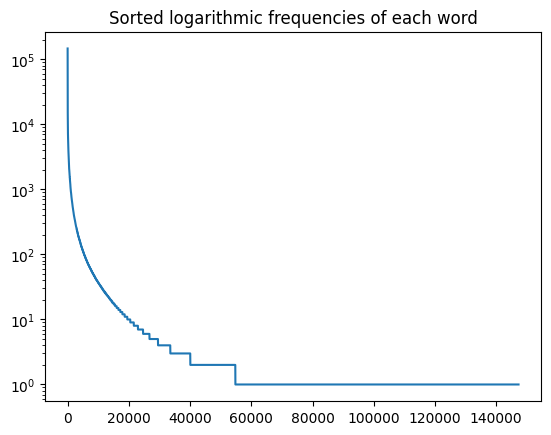

In [11]:
torchtext.disable_torchtext_deprecation_warning()

import itertools
from torchtext.vocab import vocab as vocab_maker
from collections import Counter, OrderedDict

data = imdb_data.to_numpy() if type(imdb_data) == pd.DataFrame else imdb_data

words = list(itertools.chain.from_iterable(data[:,0]))

counter = Counter(words)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)

frequencies = [x[1] for x in sorted_by_freq_tuples]

plt.plot(frequencies)
plt.title('Sorted logarithmic frequencies of each word')
plt.yscale('log')

We have over 140000 unique words, but of those more than 80000 have only occured once! Even if we embed them, their meaning will not be easily understood from their little occurance and thus context.

In [12]:
vocab_size = 30000

top_n = np.cumsum(frequencies)[vocab_size-1]/sum(frequencies)

print(f'With vocab_size = {vocab_size} we cover {top_n:.2%} of word usage.')

With vocab_size = 30000 we cover 97.47% of word usage.


If we choose the top 30000 words, these will cover 97% of the word occurances in our texts, which should be plentiful to classify their sentiment.

In [13]:
ordered_dict = OrderedDict(sorted_by_freq_tuples[:vocab_size-1])
vocab = vocab_maker(ordered_dict, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print('\033[1m'+'Original string:'+'\033[0m')
print(test_string)
print('\033[1m'+'Processed version:'+'\033[0m')
print(processed_test)
print('\033[1m'+'Vocabulary indices:'+'\033[0m')
print(vocab(processed_test))

Original string:
This film should've been titled <br> mükerrer because it was so boring. [like] [dislike]
Processed version:
['thi', 'titl', 'mkerrer', 'becaus', 'wa', 'bore']
Vocabulary indices:
[1, 322, 0, 33, 2, 193]


Notice how the `vocab_maker` utility of torchtext takes as input special tokens. We can then set the default index of the dictionary to be the unknown token. The name of the token is irrelevant, but any word that is not in our vocabulary will be mapped to index 0.

We need to process our raw data further for the model to accept it. The get_collator function defined below (adapted from ShalyginaA[$^{1}$](#di-504-lab-2)) will give us a function that can be used to process each batch.

After getting the vocabulary index of each word, we will need to handle the varying input lengths. One simple way to do this is to pad the rest of the empty space with an index (the unknown index in this case) such that the output is a proper tensor instead of a list of lists.

In [14]:
def get_collator(pad_idx):
    def collate(batch):
        texts, labels = zip(*batch)

        # words are turned into their vocabulary index
        texts = [torch.tensor(vocab(x)) for x in texts]
        # empty space is padded here, and batch dim is made the first
        texts = torch.nn.utils.rnn.pad_sequence(texts, padding_value=pad_idx, batch_first=True)

        labels = torch.tensor(labels)

        return texts, labels
    return collate

We can set seeds for the random number generators in torch using the first 3 lines below:

torch.manual_seed will mostly control stuff outside the model description, (given it is defined in the gpu) like `random_split` in this case.

Setting seeds will allow you to have reproducible code blocks and codebases, but usually for scientific research you would run experiments with different splits and model initiations and report the distribution of performance metrics across experiments.

In [15]:
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
torch.cuda.manual_seed_all(1337)

from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(data, lengths=[0.7,0.15,0.15])
next(iter(train_set))

array([list(['thi', 'desper', 'thoroughli', 'silli', 'attempt', 'keep', 'hammer', 'dracula', 'franchis', 'aliv', 'despit', 'lost', 'power', 'long', 'time', 'alreadi', 'legendari', 'vampir', 'brought', 'back', 'life', 'swing', 'london', 'exactli', 'hundr', 'year', 'wa', 'destroy', 'hi', 'archenemi', 'van', 'hels', 'occult', 'discipl', 'name', 'johnni', 'alucard', 'get', 'get', 'gather', 'hi', 'flamboy', 'friend', 'abandon', 'church', 'among', 'van', 'hels', 'great', 'granddaught', 'jessica', 'perform', 'satan', 'ritual', 'resurrect', 'dracula', 'haze', 'smoke', 'dracula', 'onli', 'mission', 'wreak', 'havoc', 'upon', 'entir', 'van', 'hels', 'lineag', 'fragil', 'jessica', 'ideal', 'victim', 'achiev', 'thi', 'thi', 'probabl', 'onli', 'goe', 'immens', 'top', 'tri', 'look', 'like', 'consid', 'previou', 'six', 'dracula', 'set', 'victorian', 'era', 'director', 'alan', 'gibson', 'realli', 'want', 'stress', 'fact', 'th', 'centuri', 'thu', 'stuff', 'hi', 'insuffer', 'hippiecharact', 'hideou', 'fa

Now that we have our dataset as an iterable object, we can wrap the DataLoader structure using the collate_fn.

In [16]:
pad_idx = 0
collator = get_collator(pad_idx)

batch_size = 64

text_len = torch.tensor([len(x[0]) for x in train_set])
train_batches = torch.split(torch.sort(text_len, descending=True)[1], batch_size)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_sampler = train_batches,
    shuffle = False, collate_fn = collator
)

valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size = batch_size,
    shuffle = False, collate_fn = collator
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size = batch_size,
    shuffle = False, collate_fn = collator
)

next(iter(train_loader))

(tensor([[   75,     0, 17084,  ...,    63,  1207,   100],
         [  605,   259,   200,  ...,     0,     0,     0],
         [ 1067,   373,  4708,  ...,     0,     0,     0],
         ...,
         [    0,  3701,  2289,  ...,     0,     0,     0],
         [   57,   545,  5747,  ...,     0,     0,     0],
         [12033,   318,   357,  ...,     0,     0,     0]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
         1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
         1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]))

As you can see, we have vocabulary indices of words for each sentence. Each batch is padded with 0's.

To reduce the computational load padding will introduce, we instructed the training dataloader to sample batches that have lengths of text close to each other.

We also have the sentiment for each sentence. (1 = Positive, 0 = Negative)

In [17]:
for i,batch in enumerate(train_loader):
    print(batch[0].shape)
    if i == 5:
        break

torch.Size([64, 1181])
torch.Size([64, 559])
torch.Size([64, 535])
torch.Size([64, 517])
torch.Size([64, 501])
torch.Size([64, 489])


## Conv1D and Conv2D

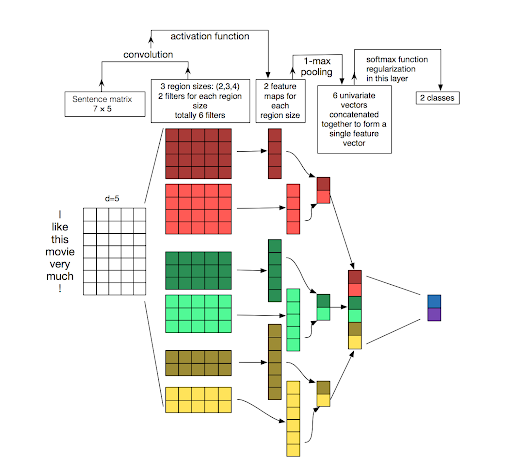

If you previously worked with CNN’s with machine vision tasks, this part sould seem similar to you. As input we have word embeddings which is essentially a 2-dimensional array like images. How we will process them actually changes with the two implementations of a convolution we will cover.

Our model structure will look similar to the figure above. After passing our corpus from different filters we will concatenate them and pass through a linear layer to obtain desired dimensions. Figure above shows a convolutional network with 3x2=6 different filters.

In PyTorch there are few different convolutional layer architectures. You maybe familiar with `Conv2D` module from image processing tasks. Because our text input is one dimensional array, we can also use `Conv1D`. Firstly let’s see the differences between these two modules.

`Conv1D` module takes 1 or 2 dimensional array as input. `in_channels` parameter is for depth of the 2nd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 2 different filters with 2 kernel size.

In [18]:
embedding = torch.nn.Embedding(10, 3)
dum= torch.tensor([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[2,5,6,2,5]])
x= embedding(dum)
print(f'Input shape: {dum.shape}')
print(f'Embedding shape: {x.shape}')
print(f'Transposed embedding shape: {x.transpose(1,2).shape}') # if we didnt have batches we could have used rot90()
cvd1 = torch.nn.Conv1d(in_channels=3, out_channels=1,kernel_size=2)
print(f'Convolved output (1D) shape: {cvd1(x.transpose(1,2)).shape}')

Input shape: torch.Size([6, 5])
Embedding shape: torch.Size([6, 5, 3])
Transposed embedding shape: torch.Size([6, 3, 5])
Convolved output (1D) shape: torch.Size([6, 1, 4])


On the other hand `Conv2D` module takes 2 or 3 dimensional arras as input. `in_channels` parameter is for depth of the 3rd dimension. `kernel_size` parameters determines sizes of the kernel and `out_channels` parameter determines how many filters will be used. Example below uses 3 different filters with 2x3 size.

In [19]:
print(f'Input shape: {dum.shape}')
print(f'Embedding shape: {x.shape}')
print(f'Expanded embedding shape: {x.unsqueeze(1).shape}')
cvd2 = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,3))  # in kernel size 2x3, 3 is the embedding dimension
print(f'Convolved output (2D) shape: {cvd2(x.unsqueeze(1)).shape}')

Input shape: torch.Size([6, 5])
Embedding shape: torch.Size([6, 5, 3])
Expanded embedding shape: torch.Size([6, 1, 5, 3])
Convolved output (2D) shape: torch.Size([6, 2, 4, 1])


For our case, a 2D convolution won't make much sense as parts of a words embedding might not correlate well with the same part of another word. There can only be correlation if we consider the whole embedding space.

If we were to set the second dimension of the kernel to 100, we would essentially be doing 1D convolution with extra steps, as we would only move forward in the sequence. Hence we will use the 1D implementation of convolutions in our model.

## Helper functions for the training loop

Here we will define functions to do training and validation at each epoch. They are written to take in different models, dataloaders and loss functions. Each function reports  

In [20]:
def accuracy(preds, y):
    """ Return accuracy per batch. """
    correct = (torch.round(torch.sigmoid(preds)) == y).float()
    return correct.sum() / len(correct)

def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for text, label in iterator:
        text, label = text.to(device), label.to(device)

        predictions = model(text).squeeze(1)
        loss = criterion(predictions, label.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy(predictions, label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0

    # Turm off dropout while evaluating
    model.eval()

    # No need to backprop in eval
    with torch.no_grad():
        for text, label in iterator:
            text, label = text.to(device), label.to(device)
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label.float())
            acc = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Training and evaluation loops were written as functions, for ease of access during multi-epoch training. Notice how on the training function we set model to "train mode", and for the evaluation one model is set to "eval mode".

## 1D Convolutional Neural Network Definition

Notice how the convolutions with different filter sizes will be done in parallel using nn.ModuleList. Once we get activation maps, we will use a pooling layer to reduce all sentences to length one by taking the maximum activation.

Result of each convolution will be concatenated after the pooling layer. While this model does not generate deep features, we will later increase the model complexity and also initialize the embeddings from pre-trained weights to improve upon it. (As you can imagine CNN's aren't used for NLP anymore, and the way they can learn deep features was understood better in computer vision tasks.)

In [21]:
from torch import nn
import torch.nn.functional as F

class CNN_1D(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, embed_dim, filter_sizes, n_filters, output_dim, dropout, pad_idx):
        super().__init__()
        # Create word embeddings from the input words
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      padding_idx = pad_idx)

        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = embed_dim,
                                              out_channels = n_filters,
                                              kernel_size = fs)
                                    for fs in filter_sizes])

        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        # Deactivate random neurons to increase robustness in training
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        '''Forward path of the network.'''
        # Get word embeddings and format them for convolutions
        embedded = self.embedding(text).transpose(1,2)

        # Perform convolutions and apply relu activation
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        # Pooling layer will reduce the sentence into 5 1x{n_filters} vectors
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Concatenate each filter response side by side to get a 1x10 vector
        # Notice the use of dropout. This will prevent memorisation (overfitting)
        cat = torch.cat(pooled, dim = 1)
        out = self.linear(self.dropout(cat))
        return out

Let's define our model parameters in a dictionary for convenience:

In [22]:
cnn_params = {
    'vocab_size': vocab_size,     # Number of words in our vocab (30000)
    'embed_dim': 100,             # Shape of the vector repr. for each word
    'filter_sizes': [1,2,3,4,5],  # N-grams we will consider
    'n_filters': 2,               # Number of filters for each N-gram
    'output_dim': 1,              # Output of our model (probability of positive)
    'dropout': 0.5,               # Proportion of units to drop in the final layer
    'pad_idx': 0                  # Location of the unknown/padding token in vocab
}

We can initiate the model by unpacking our dictionary inside the model definition. We will then send the model to the appropriate device based on the checks defined.

In [23]:

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

model = CNN_1D(**cnn_params).to(device)

For the optimizer, [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is used this time. It is more efficient than SGD in reaching the loss minima for many domains.

BCE stands for binary cross entropy, and is the standard loss function for any binary classification problem (where classes are nominal in nature). [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) is a version of BCE that combines the sigmoid activation, allowing us to not use the sigmoid in the model definition. This is argued to be slightly faster, but overall not a huge deal.

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Network optimizer

criterion = nn.BCEWithLogitsLoss() # Loss function

## Training loop in action

Bringing everything together is the loop below. It will call the train and evaluate functions defined above for 10 epochs. We will also track accuracy and loss for each epoch and print them out to track the model while its learning.

In [25]:
n_epochs = 10

train_loss, train_acc = evaluate(model, train_loader, criterion)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

val_loss = [valid_loss]
val_acc = [valid_acc]
tr_loss = [train_loss]
tr_acc = [train_acc]

for epoch in range(n_epochs):

    # Get epoch losses and accuracies
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    # Save training metrics
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    print(f'Epoch {epoch+1:2} ended.')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch  1 ended.
	Train Loss: 0.674 | Train Acc: 58.31%
	 Val. Loss: 0.548 |  Val. Acc: 75.51%
Epoch  2 ended.
	Train Loss: 0.583 | Train Acc: 68.42%
	 Val. Loss: 0.489 |  Val. Acc: 77.79%
Epoch  3 ended.
	Train Loss: 0.531 | Train Acc: 74.11%
	 Val. Loss: 0.460 |  Val. Acc: 79.58%
Epoch  4 ended.
	Train Loss: 0.493 | Train Acc: 77.29%
	 Val. Loss: 0.437 |  Val. Acc: 80.99%
Epoch  5 ended.
	Train Loss: 0.458 | Train Acc: 79.54%
	 Val. Loss: 0.422 |  Val. Acc: 81.43%
Epoch  6 ended.
	Train Loss: 0.435 | Train Acc: 81.12%
	 Val. Loss: 0.416 |  Val. Acc: 81.93%
Epoch  7 ended.
	Train Loss: 0.413 | Train Acc: 82.22%
	 Val. Loss: 0.417 |  Val. Acc: 82.22%
Epoch  8 ended.
	Train Loss: 0.393 | Train Acc: 83.53%
	 Val. Loss: 0.424 |  Val. Acc: 82.17%
Epoch  9 ended.
	Train Loss: 0.375 | Train Acc: 84.58%
	 Val. Loss: 0.434 |  Val. Acc: 81.80%
Epoch 10 ended.
	Train Loss: 0.356 | Train Acc: 85.45%
	 Val. Loss: 0.439 |  Val. Acc: 81.73%


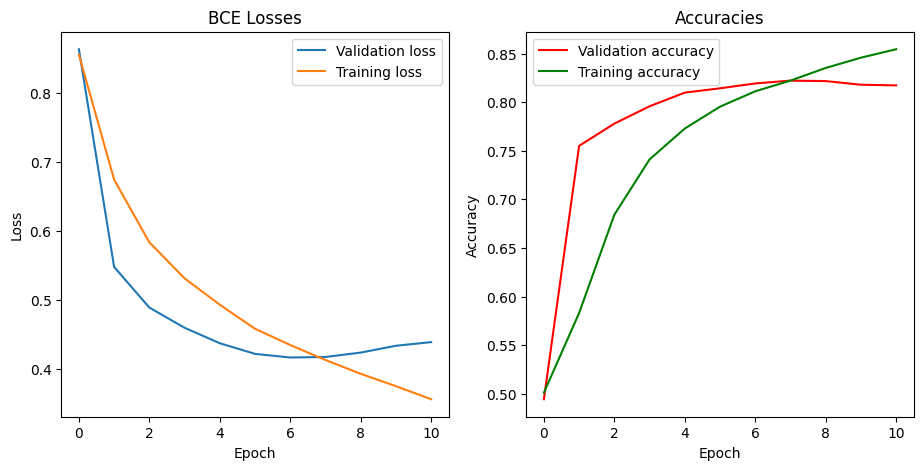

In [26]:
# Plot loss and accuracy curves
fig, ax = plt.subplots(1, 2, figsize=(11,5))

ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('BCE Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(val_acc, label='Validation accuracy', c='r')
ax[1].plot(tr_acc, label='Training accuracy', c='g')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

Since we tested the model on the two sets before any training, the models start out with poor accuracies around 50%, not better than a coin toss.

By looking at these graphs we can conclude that the model learned sufficiently until epoch 10, when the training set performance exceeded that of the validation set.

## Evaluation

With our trained model we can observe it's performance on the test set. Note that this value represents the average accuracy across all batches, though our batch size of 64 should be representative enough.

In [27]:
_, test_acc = evaluate(model, test_loader, criterion)
print(f'Accuracy of our model on the test set is: {test_acc:.2%}')

Accuracy of our model on the test set is: 81.22%


In [28]:
def sentiment(model, sentence, min_len = 5):
    '''Predict user-defined review sentiment.'''
    model.eval()
    tokenized = preprocess(sentence)
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    # Map words to word embeddings
    indexed = vocab(tokenized)

    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    # Get predicitons
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

reviews = ['This is the best movie I have ever watched!',
           'This is an okay movie, I just hated the lead',
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model, review) for review in reviews]
scores

[0.9026851654052734, 0.7068563103675842, 0.019202927127480507]

Our model seems to give accurate sentiment scores to different reviews, even those with some nuance.

In [29]:
tricky_reviews = ['This is not the best movie I have ever watched!',
           'Some would say it is an okay movie, but I found it terrific.',
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model, review) for review in tricky_reviews]
scores

[0.9026851654052734, 0.8588076233863831, 0.030514465644955635]

When given more words, the model can give more accurate results.

Remember that a rather large chunk of the words are cleaned as they don't carry much semantic meaning, like "would, is, I, it", so the model saw the same exact words for the first review in both cases.

But now the review in the middle prompts the model to give a more appropriate response.

## Increasing the number of filters

Let's now update the number of filters from 2 to 30 and see how our model performance changes.

In [30]:
cnn_params.update({'n_filters':30})
print(cnn_params)

{'vocab_size': 30000, 'embed_dim': 100, 'filter_sizes': [1, 2, 3, 4, 5], 'n_filters': 30, 'output_dim': 1, 'dropout': 0.5, 'pad_idx': 0}


In [31]:
model = CNN_1D(**cnn_params).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Network optimizer

criterion = nn.BCEWithLogitsLoss()

In [32]:
n_epochs = 10

train_loss, train_acc = evaluate(model, train_loader, criterion)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

val_loss2 = [valid_loss]
val_acc2 = [valid_acc]
tr_loss2 = [train_loss]
tr_acc2 = [train_acc]

for epoch in range(n_epochs):

    # Get epoch losses and accuracies
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    # Save training metrics
    val_loss2.append(valid_loss)
    val_acc2.append(valid_acc)
    tr_loss2.append(train_loss)
    tr_acc2.append(train_acc)

    print(f'Epoch {epoch+1:2} ended.')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2%}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2%}%')

Epoch  1 ended.
	Train Loss: 0.583 | Train Acc: 67.87%%
	 Val. Loss: 0.404 |  Val. Acc: 82.24%%
Epoch  2 ended.
	Train Loss: 0.443 | Train Acc: 79.27%%
	 Val. Loss: 0.350 |  Val. Acc: 85.22%%
Epoch  3 ended.
	Train Loss: 0.389 | Train Acc: 82.44%%
	 Val. Loss: 0.326 |  Val. Acc: 86.32%%
Epoch  4 ended.
	Train Loss: 0.341 | Train Acc: 84.98%%
	 Val. Loss: 0.307 |  Val. Acc: 86.89%%
Epoch  5 ended.
	Train Loss: 0.305 | Train Acc: 87.17%%
	 Val. Loss: 0.301 |  Val. Acc: 87.37%%
Epoch  6 ended.
	Train Loss: 0.269 | Train Acc: 88.71%%
	 Val. Loss: 0.307 |  Val. Acc: 86.87%%
Epoch  7 ended.
	Train Loss: 0.234 | Train Acc: 90.49%%
	 Val. Loss: 0.305 |  Val. Acc: 87.52%%
Epoch  8 ended.
	Train Loss: 0.199 | Train Acc: 92.16%%
	 Val. Loss: 0.315 |  Val. Acc: 87.65%%
Epoch  9 ended.
	Train Loss: 0.167 | Train Acc: 93.62%%
	 Val. Loss: 0.331 |  Val. Acc: 86.98%%
Epoch 10 ended.
	Train Loss: 0.135 | Train Acc: 94.80%%
	 Val. Loss: 0.356 |  Val. Acc: 87.17%%


In [33]:
_, test_acc = evaluate(model, test_loader, criterion)
print(f'Accuracy of our model on the test set is: {test_acc:.2%}')

Accuracy of our model on the test set is: 87.30%


This model achieves a better test set score. Let's now compare the training and validation metrics for the two models.

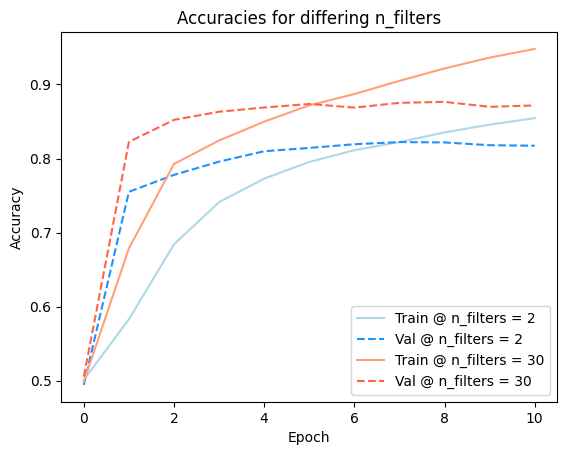

In [34]:
plt.plot(tr_acc, label='Train @ n_filters = 2', c='lightblue')
plt.plot(val_acc, label='Val @ n_filters = 2', c='dodgerblue',linestyle='dashed')
plt.plot(tr_acc2, label='Train @ n_filters = 30', c='lightsalmon')
plt.plot(val_acc2, label='Val @ n_filters = 30', c='tomato', linestyle='dashed')
plt.title('Accuracies for differing n_filters')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The more complex model achieves a better score overall, but seems to start overfitting  sooner. This is generally true for deep learning models in general. You can reduce overfitting by a couple example techniques:

* Data augmentation. (Generating new training set examples by rules or other models.)

* Schedule decreasing learning rates. (This can depend on simple functions like StepLR, Cosine Annealing or validation results).

* Parameter regularization. (i.e. via AdamW)

* Dropout. (For deeper models dropout percentages should be smaller than the example shown here.)

* Early stopping. (This can both be literally done but also to simply save checkpoints and resume training.)

Multiple techniques can be combined to achieve better results.

## Bonus: Using existing pre-trained models to accelerate training

Instead of training the embedding layer from scratch, we can utilize pre-trained GloVe ([Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)) embeddings instead.

We will use their model trained with 6 billion tokens, and an embedding dimension of 100. (Running this code will download an 800 mb file if it wasn't downloaded before.)

When we convert one of our sentences into these vectors, we will have an array of shape word length x 100

In [35]:
from torchtext.vocab import GloVe

global_vectors = GloVe(name='6B', dim=100)
global_vectors.get_vecs_by_tokens(data[0,0]).numpy()

array([[-0.22557 ,  0.49418 ,  0.4861  , ..., -0.45744 ,  0.49646 ,
         0.34906 ],
       [-0.74902 , -0.19963 ,  0.24901 , ..., -0.32662 ,  0.31207 ,
         0.58199 ],
       [-0.21568 ,  0.21229 ,  0.17246 , ..., -0.87301 , -0.1901  ,
        -0.55754 ],
       ...,
       [-0.31036 , -0.18006 ,  0.80064 , ..., -0.5341  ,  0.16042 ,
         0.15427 ],
       [-0.27313 ,  0.53893 ,  0.5334  , ...,  0.14543 , -0.30142 ,
         0.12638 ],
       [-0.48104 ,  0.025006,  0.36128 , ...,  0.18845 ,  1.2672  ,
        -0.12581 ]], dtype=float32)

To find the corresponding embeddings for our words in the dictionary we will use the `get_vecs_by_tokens` method.

Notice how the first element is again set to zeros since it represents unknown words.

We will replace the random initialization of the embedding layer in our model with these vectors.


In [36]:
word_list = sorted_by_freq_tuples[:vocab_size-1]

x = [global_vectors.get_vecs_by_tokens(x[0]) for x in word_list]

vocab_vectors = torch.cat(x).reshape(-1,cnn_params['embed_dim'])
vocab_vectors = torch.cat([torch.zeros(1,cnn_params['embed_dim']), vocab_vectors], axis=0)
vocab_vectors.shape

torch.Size([30000, 100])

We can compare the distribution of dot products between the embedding weights for our task versus the GloVe vectors. As can be seen, mostly half of the embeddings have 0 similarity when the magnitudes are also taken into account. This is to be expected as our goal of sentiment analysis does not capture many aspects of language unlike GloVe.

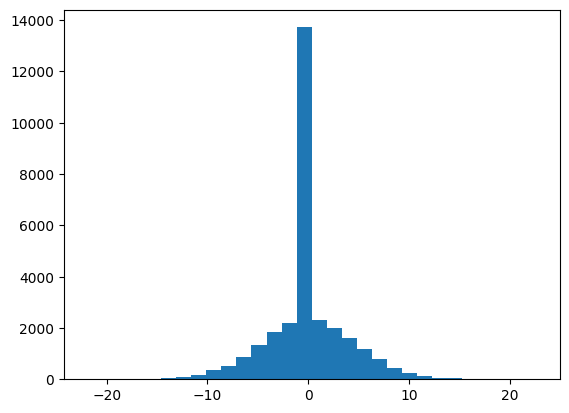

In [37]:
custom_embedding = model.embedding.weight.data.cpu()

plt.hist((vocab_vectors * custom_embedding).sum(1),bins=30);

Now let's initialize our model again with our parameters from last time. Notice after copying the contents of GloVe vectors the embedding layer is frozen by setting its' weights' `requires_grad` field to false.

In [38]:
model = CNN_1D(**cnn_params).to(device)

# load pre-trained weights from glove and freeze them
model.embedding.weight.data.copy_(vocab_vectors.to(device))
model.embedding.weight.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

This should improve training times a bit since we won't update 3 million parameters, but the forward passes will still take some time per batch.

In [39]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters in our model: {total_params} \n' \
      f'Number of trainable parameters in our model: {trainable_params}')

Total number of parameters in our model: 3045301 
Number of trainable parameters in our model: 45301


In [40]:
n_epochs = 10

train_loss, train_acc = evaluate(model, train_loader, criterion)
valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

val_loss3 = [valid_loss]
val_acc3 = [valid_acc]
tr_loss3 = [train_loss]
tr_acc3 = [train_acc]

for epoch in range(n_epochs):

    # Get epoch losses and accuracies
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    # Save training metrics
    val_loss3.append(valid_loss)
    val_acc3.append(valid_acc)
    tr_loss3.append(train_loss)
    tr_acc3.append(train_acc)

    print(f'Epoch {epoch+1:2} ended.')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2%}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2%}%')

Epoch  1 ended.
	Train Loss: 0.549 | Train Acc: 71.28%%
	 Val. Loss: 0.430 |  Val. Acc: 80.88%%
Epoch  2 ended.
	Train Loss: 0.448 | Train Acc: 78.73%%
	 Val. Loss: 0.390 |  Val. Acc: 82.91%%
Epoch  3 ended.
	Train Loss: 0.414 | Train Acc: 80.97%%
	 Val. Loss: 0.375 |  Val. Acc: 83.85%%
Epoch  4 ended.
	Train Loss: 0.391 | Train Acc: 82.33%%
	 Val. Loss: 0.370 |  Val. Acc: 83.89%%
Epoch  5 ended.
	Train Loss: 0.374 | Train Acc: 83.55%%
	 Val. Loss: 0.357 |  Val. Acc: 84.89%%
Epoch  6 ended.
	Train Loss: 0.361 | Train Acc: 84.15%%
	 Val. Loss: 0.350 |  Val. Acc: 85.26%%
Epoch  7 ended.
	Train Loss: 0.348 | Train Acc: 84.76%%
	 Val. Loss: 0.347 |  Val. Acc: 85.32%%
Epoch  8 ended.
	Train Loss: 0.334 | Train Acc: 85.59%%
	 Val. Loss: 0.348 |  Val. Acc: 85.03%%
Epoch  9 ended.
	Train Loss: 0.322 | Train Acc: 86.35%%
	 Val. Loss: 0.339 |  Val. Acc: 85.71%%
Epoch 10 ended.
	Train Loss: 0.314 | Train Acc: 86.68%%
	 Val. Loss: 0.343 |  Val. Acc: 85.51%%


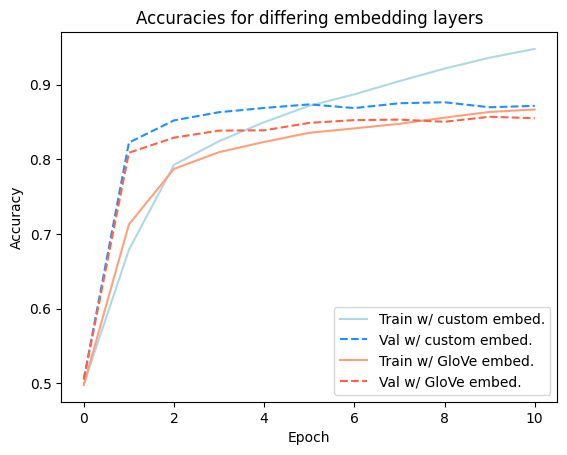

In [41]:
plt.plot(tr_acc2, label='Train w/ custom embed.', c='lightblue')
plt.plot(val_acc2, label='Val w/ custom embed.', c='dodgerblue',linestyle='dashed')
plt.plot(tr_acc3, label='Train w/ GloVe embed.', c='lightsalmon')
plt.plot(val_acc3, label='Val w/ GloVe embed.', c='tomato', linestyle='dashed')
plt.title('Accuracies for differing embedding layers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
_, test_acc = evaluate(model, test_loader, criterion)
print(f'Accuracy of our model on the test set is: {test_acc:.2%}')

Accuracy of our model on the test set is: 85.37%


As can be seen, while this version did not reach the heights of our previous model, the filters were able to find useful information from the trained weights.

While GloVe vectors have been essentially replaced by LLM's, the concept of using pre-trained models for downstream tasks has been a staple ever since. If and when certain organizations release large "foundation" models, we can benefit from the result of their pooled resources in a similar way. We will explore this concept further in assignments and lab sessions.

# Try on your own:

* Unfreeze the embedding layer so that GloVe vectors are allowed to adapt to the task at hand.

* Experiment with learning rate scheduling (for example [`StepLR()`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)) to see how the network evolves over time.

* Use different preprocessing approaches (if you are interested in NLP specifically). You can explore `mark_negation` from `nltk.sentiment.util`, different approaches to get words into their roots like lemmatization (like snowball lemmatizer, but this can take longer to preprocess).

* Look into retrieving and finetuning pre-trained language encoders such as BERT and RoBERTa utilizing a transformer architecture. You can follow this [tutorial](https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb) to get started.

# Further reading:

If you want more explanations regarding the use of Conv1D instead of Conv2D, I suggest you have a look at this [stack exchange post](https://stats.stackexchange.com/questions/292751/is-a-1d-convolution-of-size-m-with-k-channels-the-same-as-a-2d-convolution-o/292791) and [Intro to CNN blog post](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29).

If you want to refer to vision based explanations, I can recommend this section of the course notes of CS231n course offered by Standford: [Convolutional Neural Networks](https://cs231n.github.io/convolutional-networks/).